In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

C:\Users\tangj\AppData\Local\Temp\ipykernel_6044\1050323087.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("XLK", start="2024-01-01", end="2025-01-01", interval="1h")
[*********************100%***********************]  1 of 1 completed


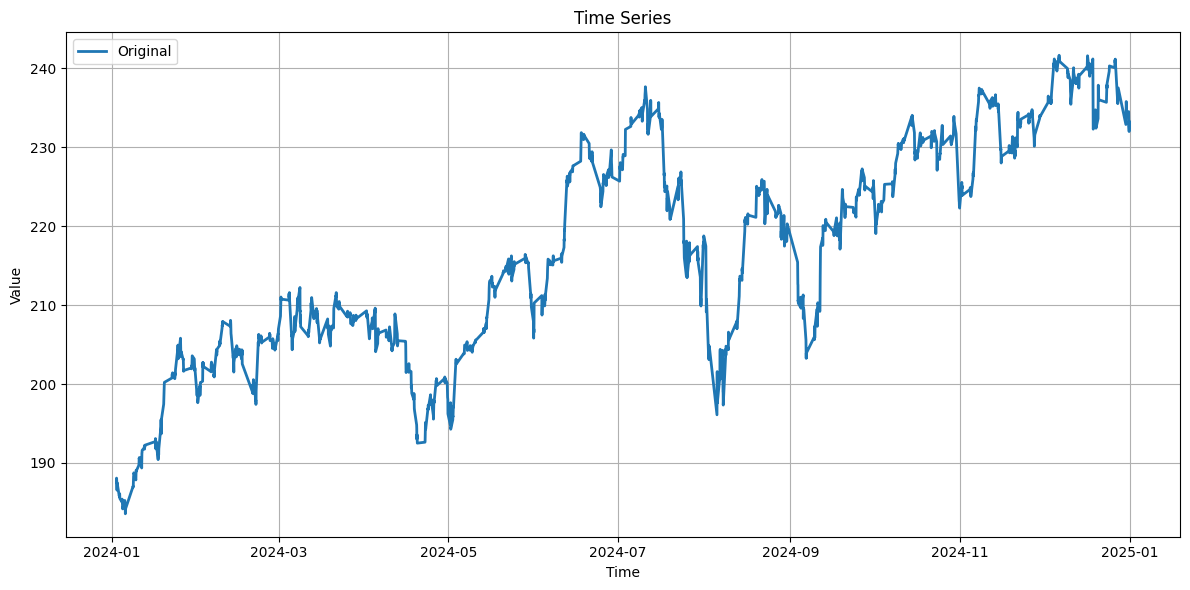

In [2]:
import yfinance as yf
import pandas as pd
from src.visualization.plots import plot_ts

df = yf.download("XLK", start="2024-01-01", end="2025-01-01", interval="1h")

ts = pd.Series(df['Close'].values.flatten(), index=df['Close'].index.tz_localize(None))
plot_ts(ts)

# 2. Modeling - Classical Statistics

## STL Model

To begin, lets start with a quick Seasonal-Trend decomposition.

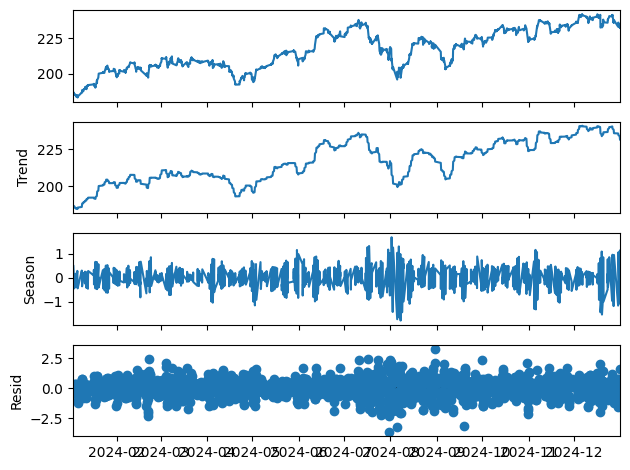

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=7) # Daily seasonality
stl_result = stl.fit()

_ = stl_result.plot()

### Investigation: Residuals

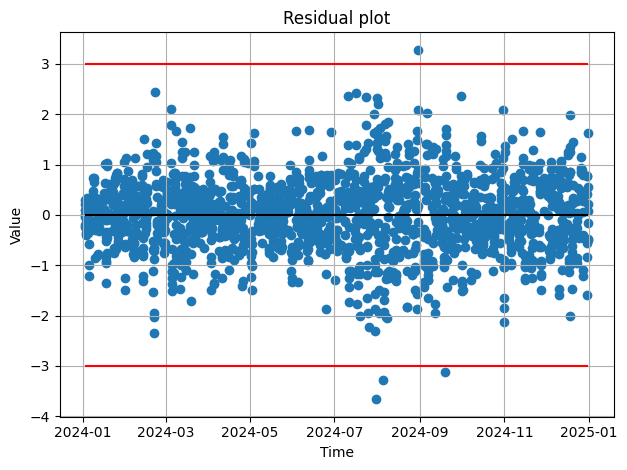

In [25]:
from src.models.preprocessing import standardize_residuals
from src.visualization.plots import plot_scatter

stl_resid = standardize_residuals(pd.Series(stl_result.resid, index=ts.index))
plot_scatter(stl_result.resid, hlines=[-3, 3])

## Rolling window

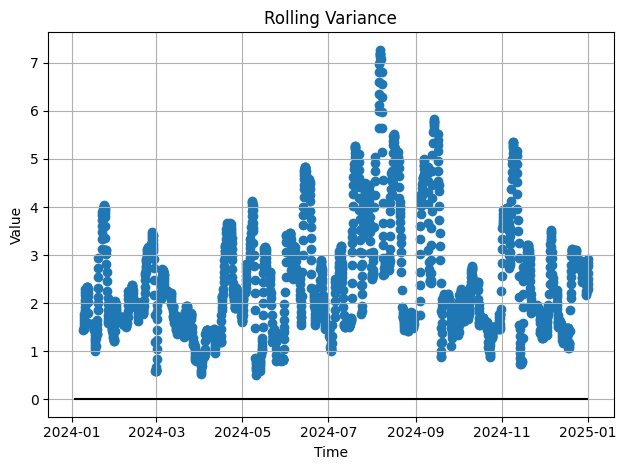

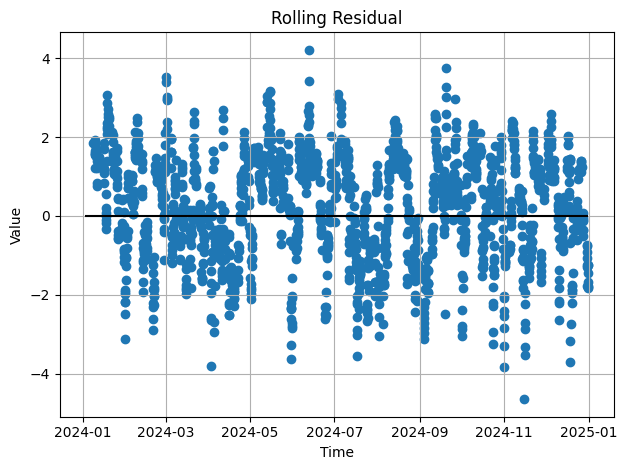

In [10]:
from src.models.statistical.rule_based import rolling_residuals, rolling_variance
from src.visualization.plots import plot_scatter

rolling_var = rolling_variance(ts, window=35)
rolling_resid = rolling_residuals(ts, window=35)

plot_scatter(rolling_var, title="Rolling Variance")
plot_scatter(rolling_resid, title="Rolling Residual")

## Kalman Filters

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


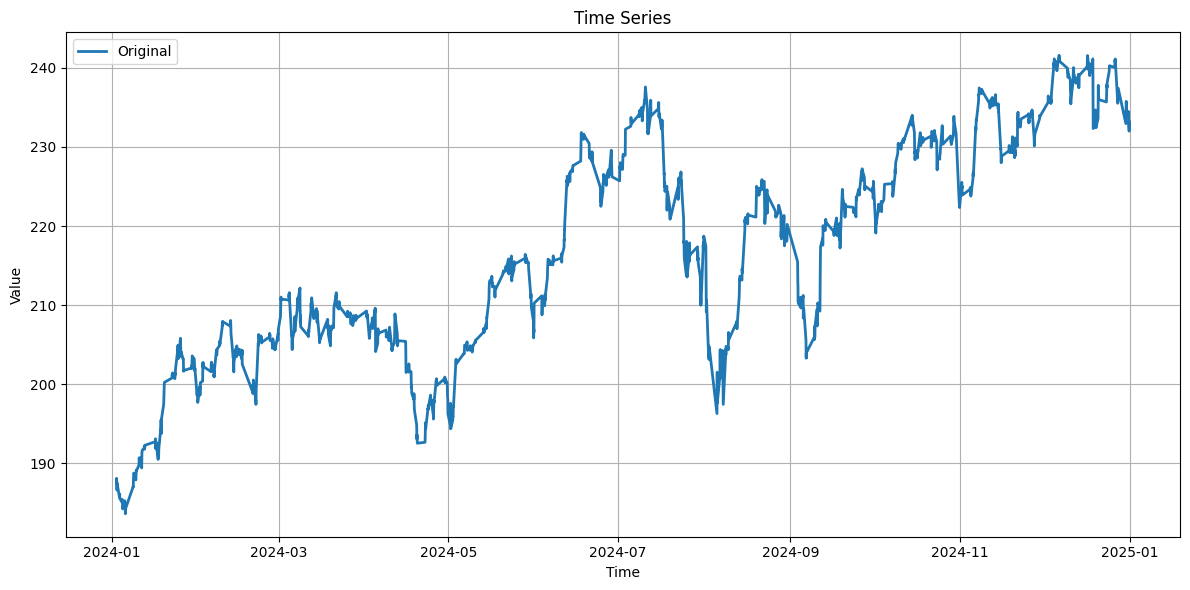

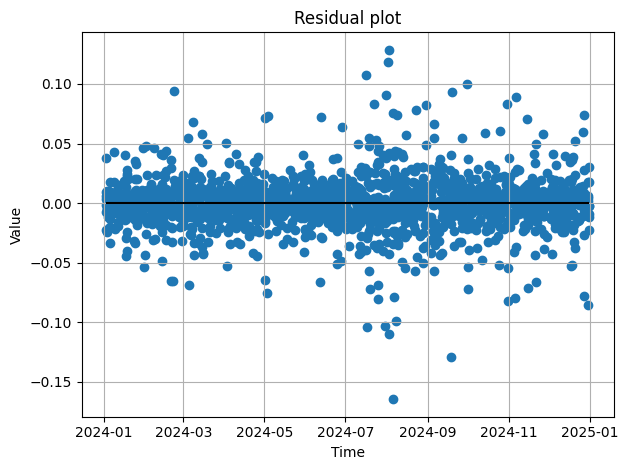

In [3]:
from src.models.statistical.kalman_filters import kalman_local_level
from src.visualization.plots import plot_ts, plot_scatter

kalman_result = kalman_local_level(ts)
plot_ts(kalman_result['level'])
plot_scatter(kalman_result['resid'])

In [7]:
from src.models.statistical.arch_models import garch_grid_search

results_table = garch_grid_search(kalman_result['resid'], max_p=2, max_q=5)
df_results = pd.DataFrame(results_table).sort_values('AIC', na_position='last')

display(df_results[['order', 'AIC', 'BIC']].head(10))


,order,AIC,BIC
9,"(1, 3)",-8833.707687,-8800.896608
8,"(1, 2)",-8804.360784,-8777.018218
11,"(1, 5)",-8802.684777,-8758.936670
10,"(1, 4)",-8784.195317,-8745.915724
7,"(1, 1)",-8751.289345,-8729.415292
16,"(2, 4)",-8730.590069,-8686.841963
17,"(2, 5)",-8729.701399,-8680.484779
6,"(1, 0)",-8701.940653,-8685.535113
15,"(2, 3)",-8693.752056,-8655.472463
14,"(2, 2)",-8680.617480,-8647.806400


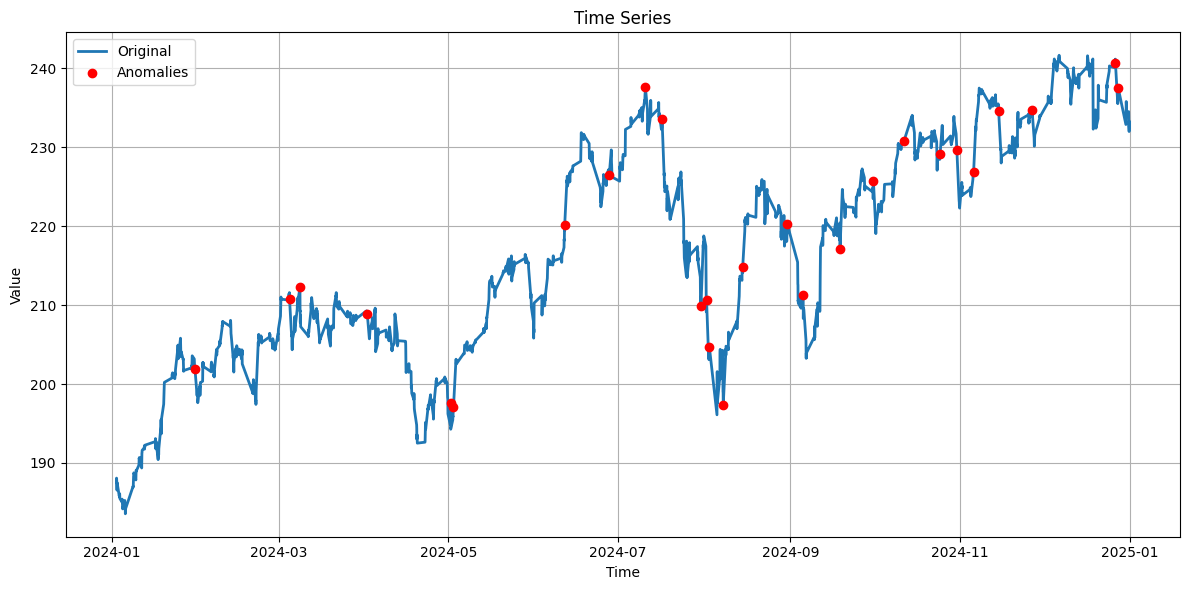

In [8]:
best_garch_model = df_results.iloc[0]

plot_ts(ts, anom=best_garch_model['anom'])

# 3 Self Trained Machine Learning models

Add Isolation forest and TCN

## LSTM Autoencoder

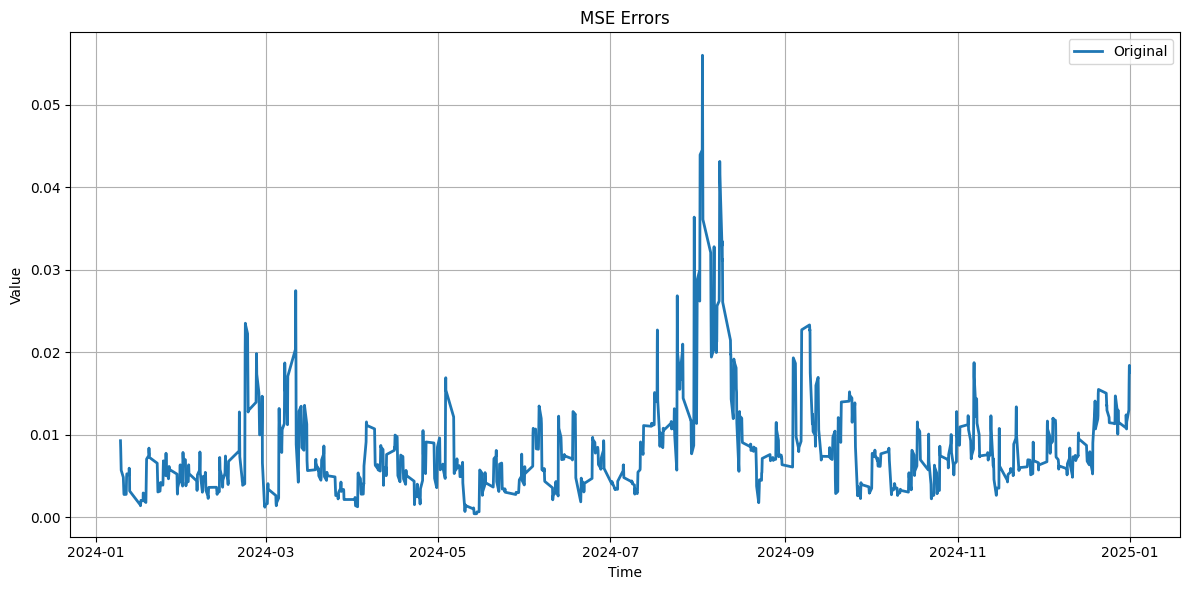

In [6]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM = model_LSTMAE(ts, window_size=35, batch_size=16, hidden_dim=16, latent_dim=16, learning_rate=0.01, epochs=50)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[35:])
plot_ts(errors_ts, title='MSE Errors')

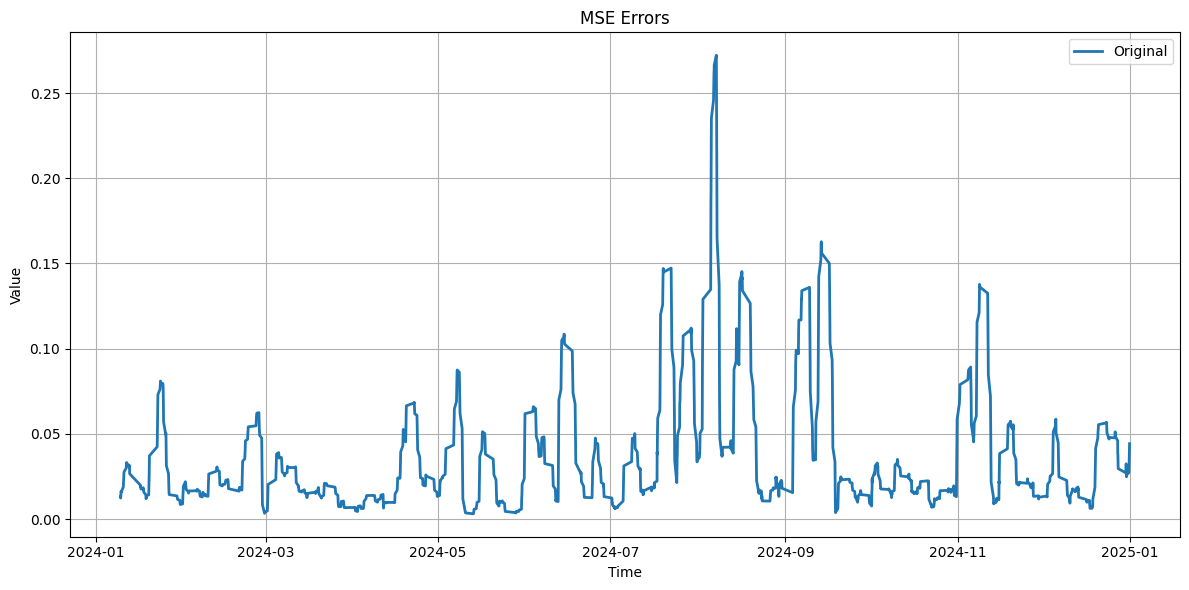

In [11]:
mse_LSTM = model_LSTMAE(ts, window_size=35, batch_size=16, hidden_dim=4, latent_dim=4, learning_rate=0.01, epochs=20)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[35:])
plot_ts(errors_ts, title='MSE Errors')

## Isolation Forest

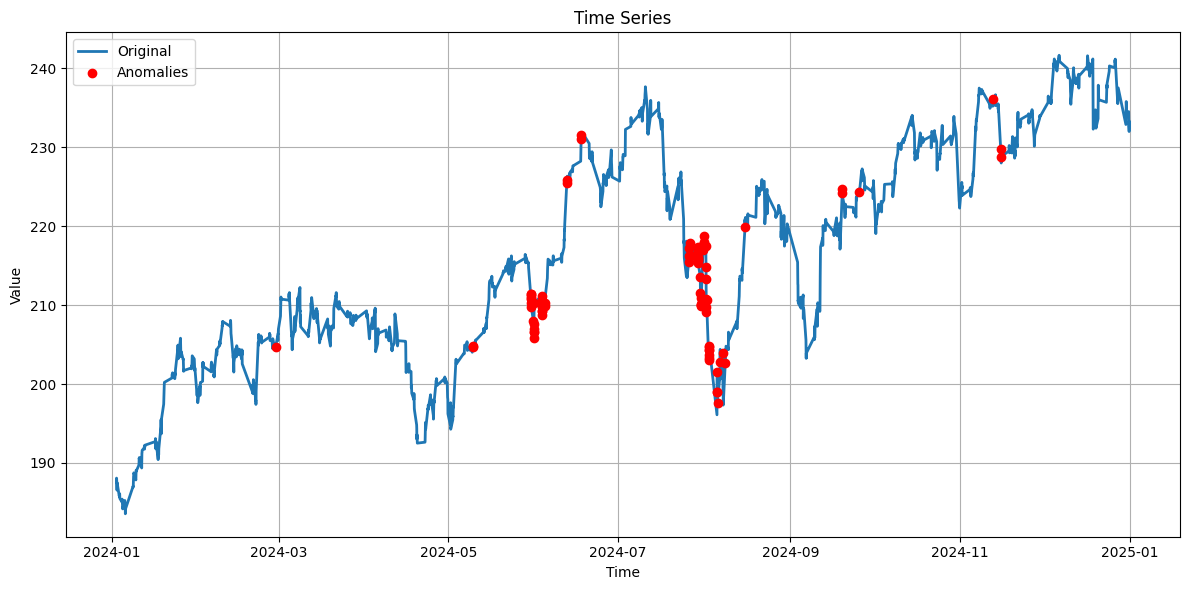

In [4]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        w = pd.Series(w)
        returns = w.pct_change().dropna()
        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],

            'mean_return': returns.mean(),
            'volatility': returns.std(),
            'max_drawdown': (w / w.cummax() - 1).min(),  
            'sharpe_ratio': returns.mean() / (returns.std() + 1e-9), 
            'return_skew': returns.skew(),
            'return_kurt': returns.kurt(),
            'autocorr_1': returns.autocorr(lag=1),
        }
        features.append(f)
    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=35)
plot_ts(ts, anom=if_results['anomaly'])


# 4 Pretrained Models

## 4.1 Prophet

14:15:34 - cmdstanpy - INFO - Chain [1] start processing
14:15:36 - cmdstanpy - INFO - Chain [1] done processing


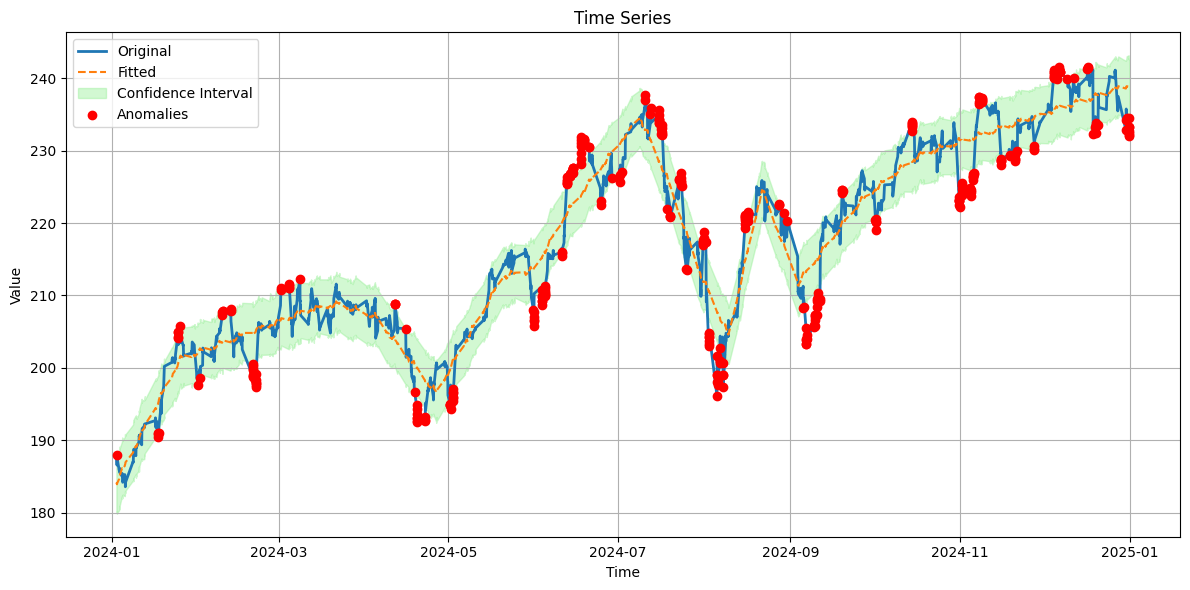

In [31]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

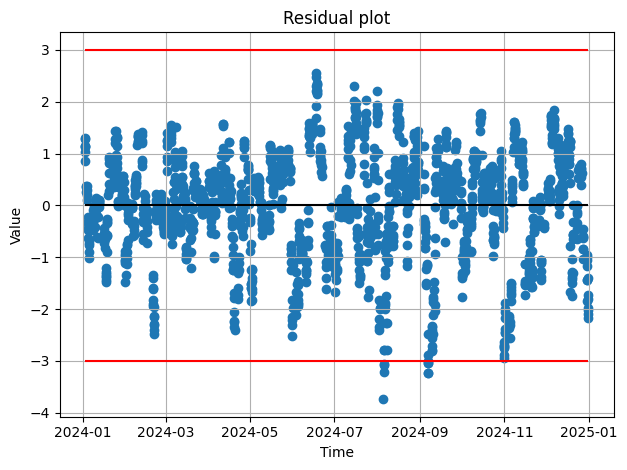

In [32]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

prophet_resid = standardize_residuals(pd.Series(prophet_df['y'].values - prophet_pred['yhat'].values, index=ts.index))
plot_scatter(prophet_resid, hlines=[-3, 3])

## 4.2 AWS Lookout for Metrics

Due to the [data size and constraint requirments](https://docs.aws.amazon.com/lookoutmetrics/latest/dev/detectors-setup.html#:~:text=Detector%20Statuses,data%20requirements.) for the AWS Lookout for Metrics model. 

AWS_df = df[['timestamp', 'value']].rename(columns={"value": "metric_value"})
print(AWS_df)

AWS_csv = './data/AWS_LfM_csv/short_seasonal_AWS.csv'
AWS_df.to_csv(AWS_csv)

import boto3

s3 = boto3.client('s3', region_name='us-east-1')
bucket_name = "time-series-anomaly-project" 

s3.upload_file(AWS_csv, bucket_name, 'short_seasonal_AWS.csv')

client = boto3.client('lookoutmetrics', region_name='us-east-1')


detector_arn = response['AnomalyDetectorArn']
client.activate_anomaly_detector(AnomalyDetectorArn=detector_arn)

client.describe_anomaly_detector(AnomalyDetectorArn=detector_arn)

response = client.get_anomaly_group(
    AnomalyGroupId='your-group-id',
    AnomalyDetectorArn=detector_arn
)

# 4. Results Summary
All models did relatively poorly on this data set